## Hyphothesis 4b: 
### The Alternative Portfolio will outperform Control Portfolio 1 and Control Portfolio 2 the 5 worst S&P500 days in 2020

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import random
import seaborn as sns
import scipy
from scipy.stats import levene
from scipy.stats import ttest_ind
import scipy.stats as stats
from time import time

os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')

In [3]:
%matplotlib notebook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Import Price/Returns Data

In [4]:
df_price = pd.read_csv('data\\processed\\df_price07_20.csv')
df_return = pd.read_csv('data\\processed\\df_return7_20.csv')

df_price.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_return.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

df_price.index = pd.to_datetime(df_price['date'])
df_return.index = pd.to_datetime(df_return['date'])

df_price = df_price.drop('date', axis=1)
df_return = df_return.drop('date', axis=1)


sp_price = df_price['SPX']
sp_return = df_return['SPX']

df_price = df_price.drop('SPX', axis=1)
df_return = df_return.drop('SPX', axis=1)

In [5]:
df_price19 = df_price[df_price.index<='2019-12-31'].sort_index()
df_price20 = df_price[(df_price.index>'2019-12-31')].sort_index()

df_return19 = df_return[df_return.index<='2019-12-31'].sort_index()
df_return20 = df_return[(df_return.index>'2019-12-31')].sort_index()

In [6]:
sp_return19 = sp_return[sp_return.index<='2019-12-31'].sort_index()
sp_return20 = sp_return[(sp_return.index>'2019-12-31')].sort_index()

In [8]:
full_companies = df_price.columns

### Find the dates of the worst trading days systemically & by the company

In [9]:
dates20 = df_price20.index

#### RETURNS: 5 worst Return dates: S&P (2007-2019)

In [10]:
worst_dates_sp19 = sp_return19.sort_values()[:5].sort_index()
worst_dates_sp19

date
2008-09-29   -0.084900
2008-10-09   -0.079420
2008-10-15   -0.087231
2008-11-20   -0.066301
2008-12-01   -0.081476
Name: SPX, dtype: float64

#### RETURNS: 5 worst Return dates: S&P 2020

In [11]:
worst_dates_sp20 = sp_return20.sort_values()[:5].sort_index()
worst_dates_sp20

date
2020-02-25   -0.034187
2020-03-09   -0.040969
2020-03-12   -0.057099
2020-03-16   -0.048816
2020-03-20   -0.052230
Name: SPX, dtype: float64

#### RETURNS: 5 worst Return dates: COMPNAY (2007-2019)

In [12]:
worst_days_returns19 = {}
for symbol in full_companies:
    temp_series = df_return19[symbol].sort_values(ascending=True).iloc[:5].sort_index()
    worst_days_returns19[symbol] = temp_series
worst_days_returns19['ORCL']

date
2007-11-08   -0.070776
2008-09-29   -0.077188
2008-10-07   -0.082559
2008-10-14   -0.085315
2008-10-15   -0.083333
Name: ORCL, dtype: float64

#### RETURNS: 5 worst Return dates: COMPNAY (2019)

In [13]:
worst_days_returns20 = {}
for symbol in full_companies:
    temp_series = df_return20[symbol].sort_values(ascending=True).iloc[:5].sort_index()
    worst_days_returns20[symbol] = temp_series
worst_days_returns20['ORCL']

date
2020-02-25   -0.039759
2020-03-03   -0.034966
2020-03-11   -0.044649
2020-03-12   -0.031983
2020-03-31   -0.054577
Name: ORCL, dtype: float64

### Generate DF 5 Worst Dates + 1 Day Behind

In [14]:
dates_back1 = []
for idx in range(1, len(dates20)):
    #print(idx)
    dates_back1.append(dates20[idx-1])
dates_back1 = pd.to_datetime(dates_back1)
df_day_behind1 = pd.DataFrame(dates_back1, index=dates20[1:], columns=['Day Behind 1'])
df_day_behind1.head()

,Day Behind 1
date,
2020-01-03,2020-01-02
2020-01-06,2020-01-03
2020-01-07,2020-01-06
2020-01-08,2020-01-07
2020-01-09,2020-01-08


In [15]:
day_behind_dates = pd.merge(df_day_behind1, worst_dates_sp20, left_index=True, right_index=True)['Day Behind 1'].values
day_behind_dates

array(['2020-02-24T00:00:00.000000000', '2020-03-06T00:00:00.000000000',
       '2020-03-11T00:00:00.000000000', '2020-03-13T00:00:00.000000000',
       '2020-03-19T00:00:00.000000000'], dtype='datetime64[ns]')

## $$For\thinspace each\thinspace  Date\thinspace  in\thinspace  the\thinspace  5\thinspace  Worst\thinspace Dates\thinspace of\thinspace 2020\thinspace$$ <br>$$H^{1}_{0}: \mu_{alt} = \mu_{ctl1} \hspace{1cm} H^{1}_{A}: \mu_{alt} > \mu_{ctl1}$$<br><br>$$H^{2}_{0}: \mu_{alt} = \mu_{ctl2} \hspace{1cm} H^{1}_{A}: \mu_{alt} > \mu_{ctl2}$$

In [21]:
n_loops = 10000
experiment_df = pd.DataFrame([])
t0 = time()

for value in range(n_loops):
    alt_list = []
    ctl_list1 = []
    for symbol in full_companies:
        temp_series = worst_days_returns19[symbol]
        temp_dates = temp_series.index
        temp_val = 0
        for date in temp_dates:
            if date in worst_dates_sp19.index:            
                temp_val +=1
        if temp_val==0:
            alt_list.append(symbol)
        else:
            ctl_list1.append(symbol)

    alt_symbols = random.sample(alt_list, 25)
    control_symbols1 = random.sample(ctl_list1, 25)
    control_symbols2 = random.sample(list(full_companies), 25)       


    ### Alternative
    alt19 = df_price19.loc[:, alt_symbols]
    alt20 = df_price20.loc[:, alt_symbols]
    con191 = df_price19.loc[:, control_symbols1]
    con201 = df_price20.loc[:, control_symbols1]
    con192 = df_price19.loc[:, control_symbols2]
    con202 = df_price20.loc[:, control_symbols2]

    worst_days_alt_portfolio20 = pd.concat([alt20.loc[worst_dates_sp20.index, :], alt20.loc[day_behind_dates, :]]).sort_index()
    worst_days_ctl1_portfolio20 = pd.concat([con201.loc[worst_dates_sp20.index, :], con201.loc[day_behind_dates, :]]).sort_index()
    worst_days_ctl2_portfolio20 = pd.concat([con202.loc[worst_dates_sp20.index, :], con202.loc[day_behind_dates, :]]).sort_index()

    alt_values_worst_days20 = worst_days_alt_portfolio20.apply(sum, axis=1)
    ctl1_values_worst_days20 = worst_days_ctl1_portfolio20.apply(sum, axis=1)
    ctl2_values_worst_days20 = worst_days_ctl2_portfolio20.apply(sum, axis=1)


    comparison_dic = {}
    temp_experiment = pd.DataFrame([])
    idx=0
    for i in range(10):
        if i % 2 == 0:
            pass
        else:
            temp_idx = alt_values_worst_days20.index[i]        
            temp_sp = worst_dates_sp19[worst_dates_sp20.index==temp_idx].values[0]

            temp_start_ctl1 = ctl1_values_worst_days20[i-1]
            temp_start_ctl2 = ctl2_values_worst_days20[i-1]        
            temp_start_alt = alt_values_worst_days20[i-1]

            temp_end_ctl1 = ctl1_values_worst_days20[i]
            temp_end_ctl2 = ctl2_values_worst_days20[i]        
            temp_end_alt = alt_values_worst_days20[i]        

            temp_ret_ctl1 = (temp_end_ctl1-temp_start_ctl1)/temp_end_ctl1
            temp_ret_ctl2 = (temp_end_ctl2-temp_start_ctl2)/temp_end_ctl2        
            temp_ret_alt = (temp_end_alt-temp_start_alt)/temp_end_alt        
            #print(temp_end, temp_start)

            comparison_dic['date'] = temp_idx       
            comparison_dic['SPX'] =  temp_sp
            comparison_dic['CTL1'] = temp_ret_ctl1
            comparison_dic['CTL2'] = temp_ret_ctl2        
            comparison_dic['ALT'] = temp_ret_alt
            comparison_dic['sample'] = value+1
            temp_df = pd.DataFrame([comparison_dic])
            temp_experiment = pd.concat([temp_experiment, temp_df])

    experiment_df = pd.concat([experiment_df, temp_experiment])
    if value % 500 == 0:
        t1 = time()  
        print('{} minutes have passed'.format(round((t1-t0)/60, 4)))

print('finished')
experiment_df = experiment_df.sort_values(by=['date', 'sample'])
experiment_df.head(1)

0.0013 minutes have passed
0.6676 minutes have passed
1.3337 minutes have passed
1.9494 minutes have passed
2.5909 minutes have passed
3.2121 minutes have passed
3.8812 minutes have passed
4.5154 minutes have passed
5.1241 minutes have passed
5.825 minutes have passed
6.4635 minutes have passed
7.2049 minutes have passed
7.8438 minutes have passed
8.5303 minutes have passed
9.0389 minutes have passed
9.5382 minutes have passed
10.0538 minutes have passed
10.5638 minutes have passed
11.0464 minutes have passed
11.5439 minutes have passed
finished


,date,SPX,CTL1,CTL2,ALT,sample
0,2020-02-25,-0.0849,-0.032083,-0.034589,-0.029102,1


In [27]:
alpha=0.05
z_critical = 1.645
hypothesis_df = pd.DataFrame([])

for date in worst_dates_sp20.index:
    temp_dic = {}
    temp_df = experiment_df[experiment_df['date']==date]
    temp_ctl1 = temp_df['CTL1'] 
    temp_ctl2 = temp_df['CTL2'] 
    temp_alt = temp_df['ALT']

    ### Z - Test
    x_bar_alt = temp_alt.mean()
    x_bar_ctl1 = temp_ctl1.mean()
    x_bar_ctl2 = temp_ctl2.mean()
    std_error1 = np.sqrt(temp_alt.var()+temp_ctl1.var()-2*np.cov(temp_alt, temp_ctl1)[0][1])
    std_error2 = np.sqrt(temp_alt.var()+temp_ctl2.var()-2*np.cov(temp_alt, temp_ctl2)[0][1])    
    z_hat1 = (x_bar_alt-x_bar_ctl1)/std_error1
    z_hat2 = (x_bar_alt-x_bar_ctl2)/std_error2    
    ## Generate P-values
    p1 = 1-stats.norm.cdf(z_hat1)
    p2 = 1-stats.norm.cdf(z_hat2)
    
    ### Generate Upper/Lower Bounds
    t_lower1 = x_bar_alt-std_error1*z_critical
    t_lower2 = x_bar_alt-std_error2*z_critical    
    t_upper1 = x_bar_alt+std_error1*z_critical
    t_upper2 = x_bar_alt+std_error2*z_critical    

    ### Append Dataframe
    temp_dic['Check Date'] = date    
    temp_dic['x_bar_alt'] = x_bar_alt 
    temp_dic['lower1'] = t_lower1
    temp_dic['upper1'] = t_upper1
    temp_dic['P1A'] = p1
    temp_dic['H1A'] = ['Reject' if p1 < alpha else 'Accept']    
    temp_dic['lower2'] = t_lower2
    temp_dic['upper2'] = t_upper2
    temp_dic['P2A'] = p2
    temp_dic['H2A'] = ['Reject' if p2 < alpha else 'Accept']
    
    temp_df = pd.DataFrame(temp_dic)
    hypothesis_df = pd.concat([hypothesis_df, temp_df])

hypothesis_df.to_csv('plots\\h4b\\hypothesis_test_s10000_1.csv') 
hypothesis_df        

,Check Date,x_bar_alt,lower1,upper1,P1A,H1A,lower2,upper2,P2A,H2A
0,2020-02-25,-0.030163,-0.037900,-0.022425,0.290670,Accept,-0.037932,-0.022393,0.308574,Accept
0,2020-03-09,-0.083095,-0.106932,-0.059257,0.672529,Accept,-0.107175,-0.059014,0.669281,Accept
0,2020-03-12,-0.112948,-0.136636,-0.089261,0.677823,Accept,-0.136503,-0.089393,0.674088,Accept
0,2020-03-16,-0.119702,-0.159606,-0.079798,0.188585,Accept,-0.159226,-0.080178,0.206702,Accept
0,2020-03-20,-0.019238,-0.056118,0.017642,0.048628,Reject,-0.056901,0.018425,0.063688,Accept


<IPython.core.display.Javascript object>


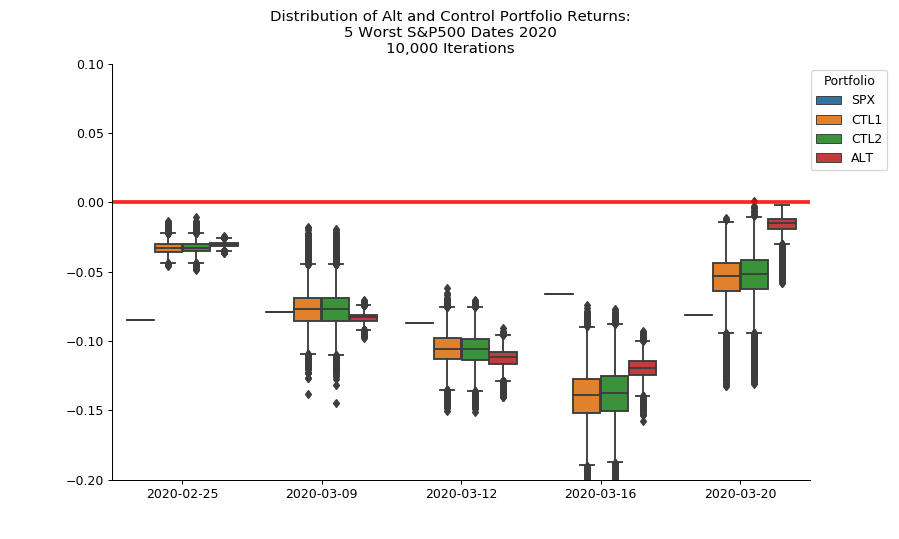

<IPython.core.display.Javascript object>


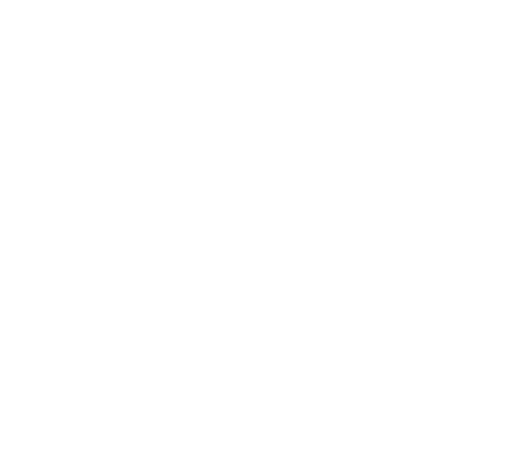

In [25]:
plot_boxplots(experiment_df)

In [24]:
def plot_boxplots(df):
    fig, ax = plt.subplots(figsize=(10,6))
    
    temp_df = df.iloc[:, :-1]
    melted_df = pd.melt(df,id_vars=['date'], value_vars=['SPX', 'CTL1', 'CTL2', 'ALT'],
                var_name = 'portfolio', value_name='returns')

    g = sns.catplot(ax=ax, data=melted_df, kind='box', x='date', y='returns', hue='portfolio', legend=True, legend_out=True)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')        

    #ax.set_title('Samples={}, P_Size={}'.format(sample_size, p_size), fontsize=20)
    ax.set_xticklabels(['2020-02-25', '2020-03-09', '2020-03-12', '2020-03-16', '2020-03-20'])
    ax.tick_params(axis="x", rotation=0)
    #ax.axhline(return_sp19, color='red', alpha=0.7, label='SP500 2019/2020')
    #ax.axhline(return_sp20, color='red', alpha=0.7)
    ax.axhline(0, color='red', alpha=0.85, linewidth=3)
    ax.set_ylim(-0.2, 0.1)

    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.12,1), title='Portfolio', fontsize=10)
    legend.get_title().set_fontsize('10')

    fig.suptitle('Distribution of Alt and Control Portfolio Returns:\n5 Worst S&P500 Dates 2020\n{:,} Iterations'.format(n_loops))
    #fig.text(0.5, 0.04, 'R Threshold', ha='center', va='center', fontsize=15)
    #fig.text(0.06, 0.5, 'Portfolio Return', ha='center', va='center', rotation=90, fontsize=15)
    fig.subplots_adjust(hspace=0.5)
    #plt.tight_layout()
    plt.close()
    plt.show()